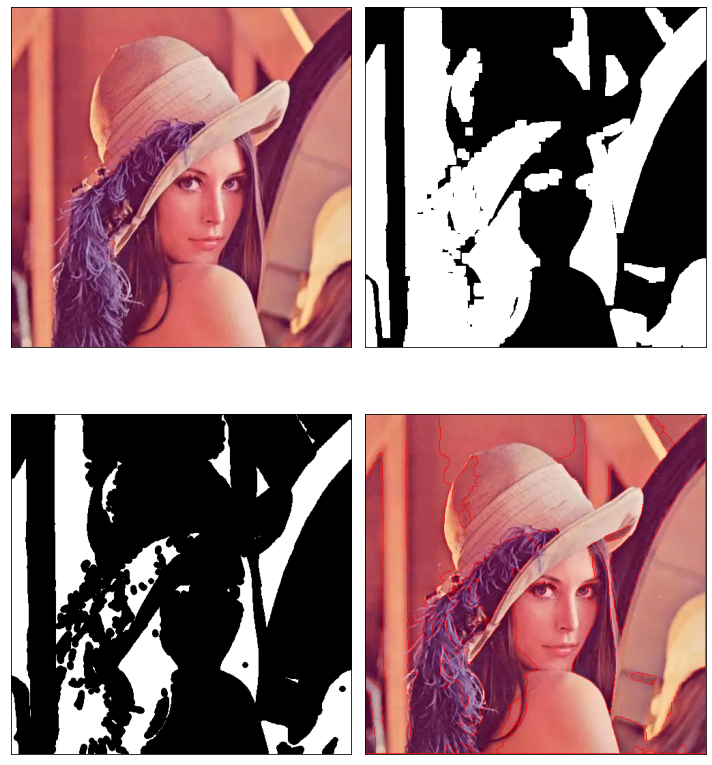

In [14]:
"""
完成分水岭算法步骤：
1、加载原始图像
2、阈值分割，将图像分割为黑白两个部分
3、对图像进行开运算，即先腐蚀在膨胀
4、对开运算的结果再进行 膨胀，得到大部分是背景的区域
5、通过距离变换 Distance Transform 获取前景区域
6、背景区域sure_bg 和前景区域sure_fg相减，得到即有前景又有背景的重合区域
7、连通区域处理
8、最后使用分水岭算法
"""

import cv2
import numpy as np
from matplotlib import pyplot as plt

# Step1. 加载图像
img = cv2.imread('./lena.jpg')
last_img=img.copy() # 如果只是直接复制 修改last_img会影响img 
gray = cv2.cvtColor(last_img, cv2.COLOR_BGR2GRAY)  # 变成灰度图

# Step2.阈值分割，将图像分为黑白两部分
ret, thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

# Step3. 对图像进行“开运算”，先腐蚀再膨胀
kernel = np.ones((3, 3), np.uint8)
opening = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)

# Step4. 对“开运算”的结果进行膨胀，得到大部分都是背景的区域
sure_bg = cv2.dilate(opening, kernel, iterations=3)

# Step5.通过distanceTransform获取前景区域
dist_transform = cv2.distanceTransform(opening, cv2.DIST_L2, 5)  # DIST_L1 DIST_C只能 对应掩膜为3    DIST_L2 可以为3或者5
ret, sure_fg = cv2.threshold(dist_transform, 0.1 * dist_transform.max(), 255, 0)

# Step6. sure_bg与sure_fg相减,得到既有前景又有背景的重合区域   #此区域和轮廓区域的关系未知 
sure_fg = np.uint8(sure_fg)
unknow = cv2.subtract(sure_bg, sure_fg)

# Step7. 连通区域处理
ret, markers = cv2.connectedComponents(sure_fg,connectivity=8) #对连通区域进行标号  序号为 0 - N-1 
markers = markers + 1           #OpenCV 分水岭算法对物体做的标注必须都 大于1 ，背景为标号 为0  因此对所有markers 加1  变成了  1  -  N

#去掉属于背景区域的部分（即让其变为0，成为背景）
# 此语句的Python语法 类似于if ，“unknow==255” 返回的是图像矩阵的真值表。
markers[unknow==255] = 0   

# Step8.分水岭算法
markers = cv2.watershed(last_img, markers)  #分水岭算法后，所有轮廓的像素点被标注为  -1 

last_img[markers == -1] = [0, 0, 255]   # 标注为-1 的像素点标红

#显示图像
plt.figure(figsize=(10, 12))
# opencv 以BGR模式读图，plt以RGB展示图片 需要转换
sure_bg=cv2.cvtColor(sure_bg,cv2.COLOR_BGR2RGB)
sure_fg=cv2.cvtColor(sure_fg,cv2.COLOR_BGR2RGB)
last_img=cv2.cvtColor(last_img,cv2.COLOR_BGR2RGB)
img=cv2.cvtColor(img,cv2.COLOR_BGR2RGB)

plt.subplot(221), plt.imshow(img), plt.xticks([]), plt.yticks([])
plt.subplot(222), plt.imshow(sure_bg), plt.xticks([]), plt.yticks([])
plt.subplot(223), plt.imshow(sure_fg), plt.xticks([]), plt.yticks([])
plt.subplot(224), plt.imshow(last_img), plt.xticks([]), plt.yticks([])
plt.tight_layout()
plt.show()

